# Предсказание уровня активности аэропортов в Бразилии,
## Постановка задачи:

Исходные данные:

In [2]:
import sys
sys.path.append('../')
from stable_gnn.graph import Graph
from stable_gnn.pipelines.node_classification_pipeline import TrainModelNC, TrainModelOptunaNC

import torch_geometric.transforms as T
import torch



In [14]:
root = '../data_validation/'
name='brazil'
dataset = Graph(root=root + str(name), name=name, transform=T.NormalizeFeatures(),adjust_flag=False)
data = dataset[0]
len(data.edge_index[0])

Processing...
Done!


1074

Решаем задачу предсказания связей, пользуясь подготовленным пайплайном в stable_gnn.pipelines.train_model_pipeline

In [8]:
data.num_nodes

131

[I 2022-12-19 15:36:22,479] A new study created in memory with name: no-name-8f8cc4ad-1169-455c-b3c2-bd3766293996
[I 2022-12-19 15:36:26,072] Trial 0 finished with value: 3.5292282104492188 and parameters: {'hidden_layer': 256, 'dropout': 0.4, 'size of network, number of convs': 3, 'lr': 0.007645946201031369, 'num_negative_samples': 21, 'alpha': 0.5}. Best is trial 0 with value: 3.5292282104492188.
[I 2022-12-19 15:36:28,056] Trial 1 finished with value: 4.2328572273254395 and parameters: {'hidden_layer': 64, 'dropout': 0.1, 'size of network, number of convs': 3, 'lr': 0.0050631857216007145, 'num_negative_samples': 6, 'alpha': 0.7}. Best is trial 0 with value: 3.5292282104492188.
[I 2022-12-19 15:36:29,556] Trial 2 finished with value: 4.341424942016602 and parameters: {'hidden_layer': 256, 'dropout': 0.1, 'size of network, number of convs': 1, 'lr': 0.008809467885590545, 'num_negative_samples': 11, 'alpha': 0.8}. Best is trial 0 with value: 3.5292282104492188.
[I 2022-12-19 15:36:32,6

Loss: 0.7000, Epoch: 099, test acc micro: 0.4815, test acc macro: 0.4812


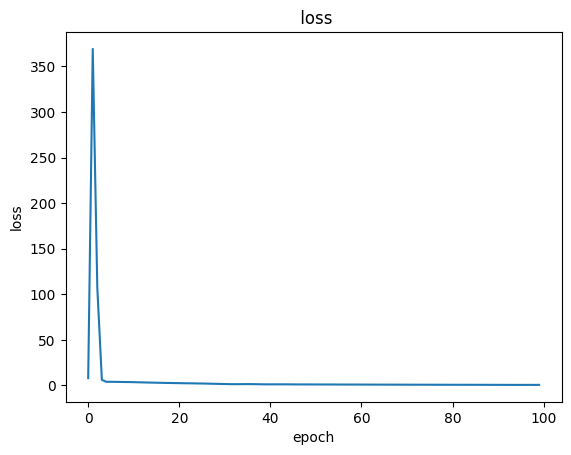

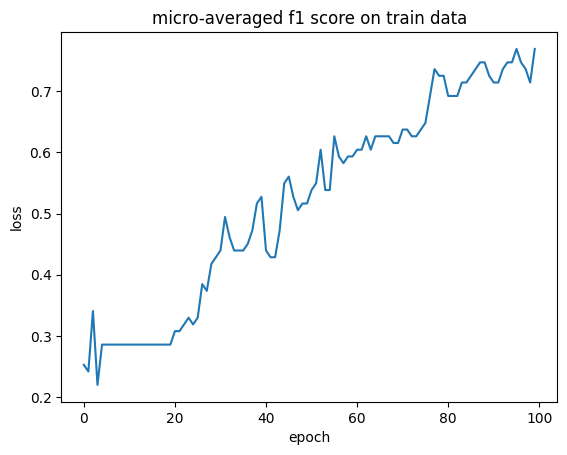

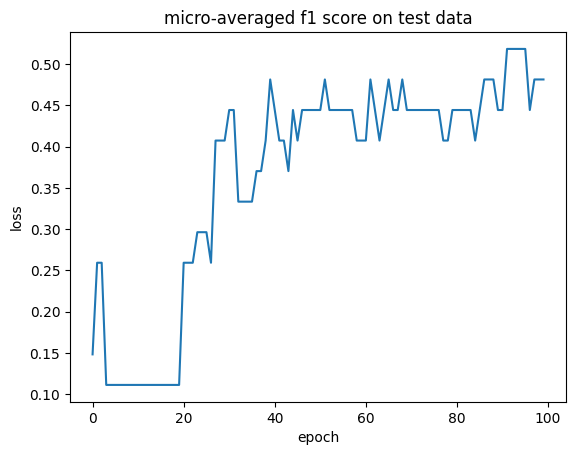

0.7692307692307693 0.48148148148148145


In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_name='APP'
ssl_flag = False

params = {'hidden_layer': 128, "size of network, number of convs": 3, "dropout": 0.1, "lr": 0.01, "coef": 10}
model_training = TrainModelNC(data=dataset, device=device, ssl_flag=ssl_flag, loss_name=loss_name)
model, train_acc_mi, train_acc_ma, test_acc_mi, test_acc_ma = model_training.run(params)
print(train_acc_mi, test_acc_mi)

emb tensor([[ 4.7008e-01,  1.3665e-01],
        [ 3.8551e-01,  4.5552e-01],
        [ 2.0626e-01,  8.2390e-01],
        [ 7.9179e-01,  4.9448e-01],
        [ 1.7649e-01,  7.1064e-01],
        [ 7.3613e-01,  7.8266e-01],
        [ 5.0632e-01,  1.4800e-01],
        [ 3.1588e-01,  7.0463e-01],
        [-2.6779e-01,  7.2261e-02],
        [-2.7677e-01,  7.6126e-01],
        [ 5.2102e-01,  1.9263e-01],
        [-1.1938e+00, -1.2899e+00],
        [-7.0304e-01, -1.0594e+00],
        [ 5.3311e-01, -7.7420e-01],
        [-1.1617e+00, -8.6967e-01],
        [ 4.9113e-01,  8.3645e-02],
        [-5.6410e-01, -1.0359e+00],
        [ 7.3386e-01, -4.6242e-01],
        [ 3.6656e-01,  6.6068e-02],
        [ 3.6731e-01, -6.1507e-01],
        [ 2.6833e-02, -5.0796e-01],
        [ 6.7889e-01, -5.5471e-02],
        [ 3.4173e-02,  2.8022e-01],
        [-7.1509e-01,  8.3504e-02],
        [ 4.4183e-01,  6.7240e-01],
        [ 6.6307e-02,  6.2625e-01],
        [-3.9805e-01, -2.5324e-01],
        [ 5.6057e-01,  1

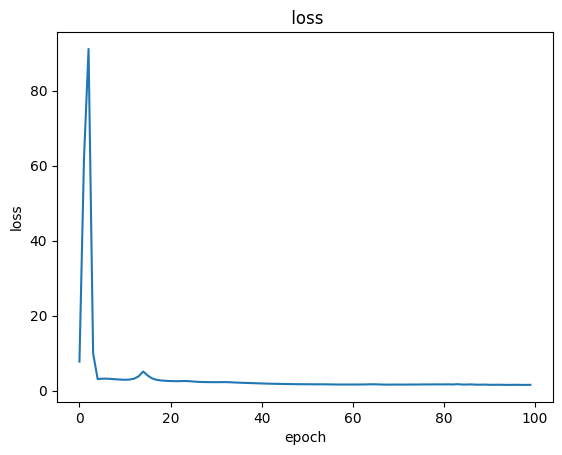

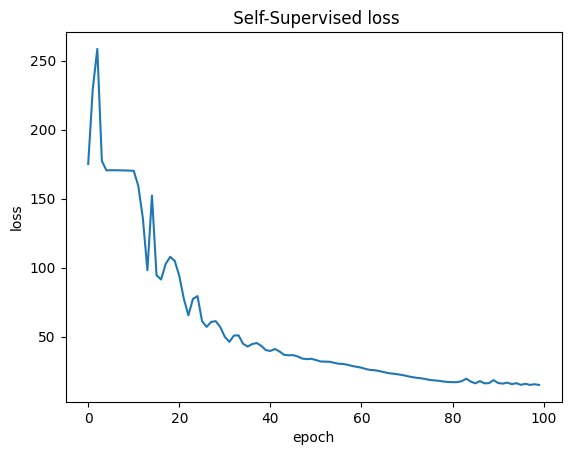

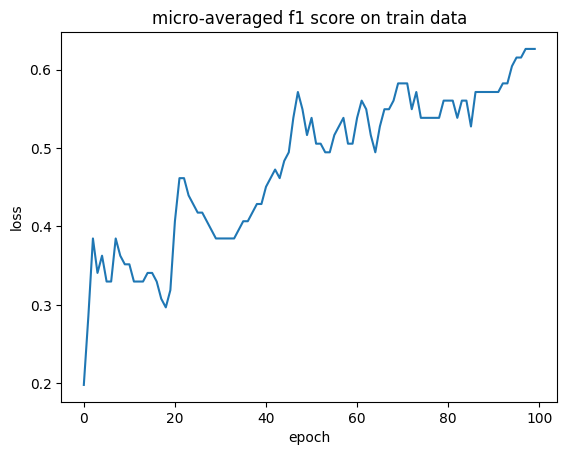

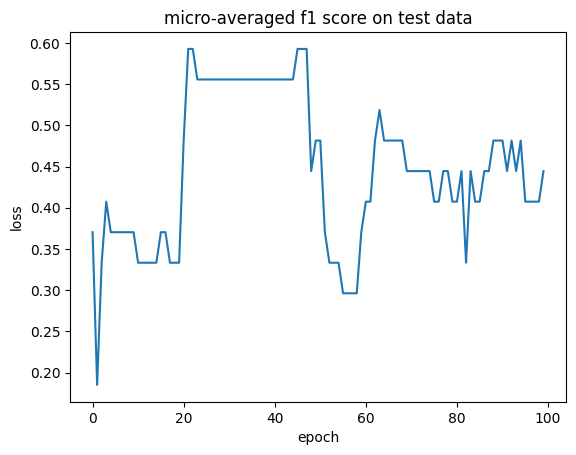

0.6263736263736264 0.4444444444444444


In [6]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_name='APP'
ssl_flag = True

params = {'hidden_layer': 64, "size of network, number of convs": 3, "dropout": 0.1, "lr": 0.01, "coef": 10}
model_training = TrainModelNC(data=dataset, device=device, ssl_flag=ssl_flag, loss_name=loss_name)
model, train_acc_mi, train_acc_ma, test_acc_mi, test_acc_ma = model_training.run(params)
print(train_acc_mi, test_acc_mi)

# Если уточнить структуру
удалим датасет и загрузим снова с другим флагом:

In [17]:
root = '../data_validation/'
name='brazil'
dataset = Graph(root=root + str(name), name=name, transform=T.NormalizeFeatures(),adjust_flag=True)
data = dataset[0]

print(len(data.edge_index[0]))

Processing...


118


Done!


[I 2022-12-19 15:41:44,926] A new study created in memory with name: no-name-8479ed15-ac3d-4abe-b167-2e7f6e89a230
[I 2022-12-19 15:41:46,091] Trial 0 finished with value: 5.572658061981201 and parameters: {'hidden_layer': 32, 'dropout': 0.1, 'size of network, number of convs': 3, 'lr': 0.008463696713354013, 'num_negative_samples': 1, 'alpha': 0.8}. Best is trial 0 with value: 5.572658061981201.
[I 2022-12-19 15:41:46,912] Trial 1 finished with value: 6.936990737915039 and parameters: {'hidden_layer': 32, 'dropout': 0.2, 'size of network, number of convs': 2, 'lr': 0.005200921882606579, 'num_negative_samples': 16, 'alpha': 0.8}. Best is trial 0 with value: 5.572658061981201.
[I 2022-12-19 15:41:47,694] Trial 2 finished with value: 7.0655131340026855 and parameters: {'hidden_layer': 64, 'dropout': 0.2, 'size of network, number of convs': 3, 'lr': 0.005988063236811605, 'num_negative_samples': 21, 'alpha': 0.9}. Best is trial 0 with value: 5.572658061981201.
[I 2022-12-19 15:41:49,436] Tri

Loss: 0.3183, Epoch: 099, test acc micro: 0.2593, test acc macro: 0.2622


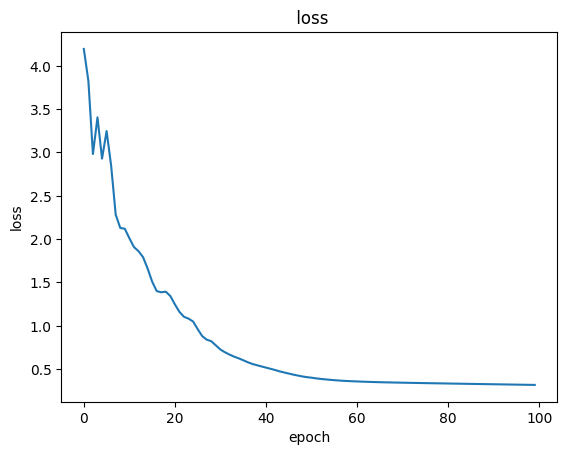

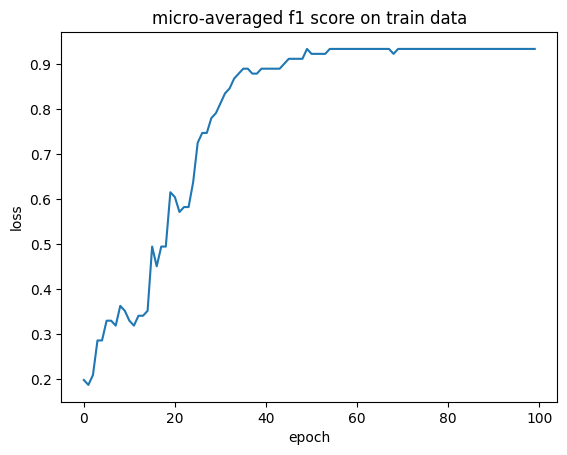

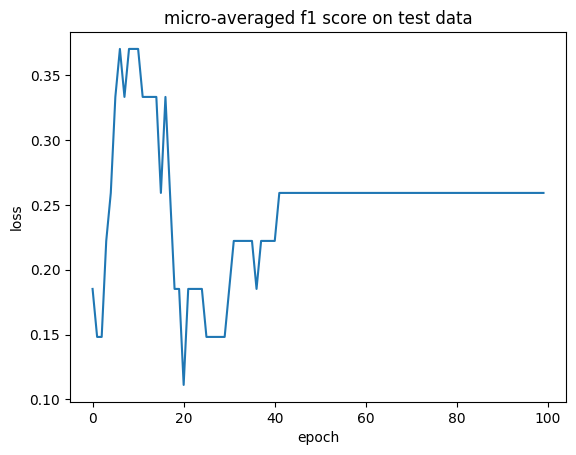

0.9340659340659341 0.25925925925925924


In [11]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_name='APP'
ssl_flag = False

params = {'hidden_layer': 128, "size of network, number of convs": 3, "dropout": 0.1, "lr": 0.01, "coef": 10}
model_training = TrainModelNC(data=dataset, device=device, ssl_flag=ssl_flag, loss_name=loss_name)
model, train_acc_mi, train_acc_ma, test_acc_mi, test_acc_ma = model_training.run(params)
print(train_acc_mi, test_acc_mi)

emb tensor([[-5.4656e-02,  1.3592e-01],
        [ 1.6188e-01,  7.2104e-02],
        [ 1.5965e-01,  4.9707e-01],
        [-1.2006e-03,  2.3271e-03],
        [-3.9560e-01,  3.6977e-01],
        [ 6.7809e-02, -1.3962e-01],
        [-2.6182e-01,  9.3696e-02],
        [ 2.0262e-01, -3.9489e-01],
        [-6.3890e-04,  2.0542e-03],
        [-2.6133e-02,  2.5536e-03],
        [ 4.4071e-04,  1.6819e-03],
        [ 1.6499e-01, -1.0201e-01],
        [-2.5198e-02, -2.9872e-01],
        [ 1.8582e-01, -3.5894e-01],
        [-2.1138e-01, -2.1244e-01],
        [-2.3308e-01,  1.1643e-02],
        [-9.3146e-02,  2.0491e-01],
        [ 2.1696e-01, -9.1353e-02],
        [ 4.3715e-01, -2.5141e-01],
        [ 3.6193e-01, -1.9264e-01],
        [ 3.7598e-01, -1.4389e-01],
        [-3.6624e-01, -2.0414e-02],
        [ 4.1770e-02, -5.4785e-01],
        [-6.7864e-02,  5.8798e-01],
        [-5.8271e-02,  2.0637e-01],
        [-2.5557e-01, -2.0989e-02],
        [ 4.1172e-01,  3.1009e-02],
        [-8.7142e-04,  2

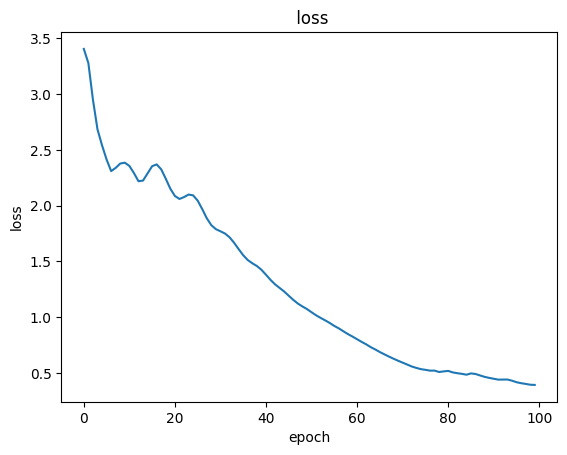

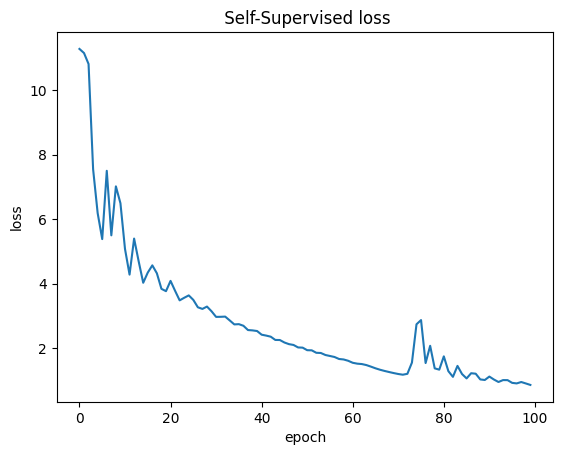

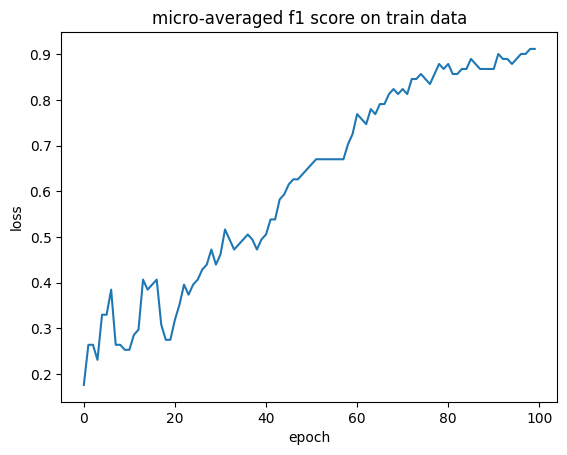

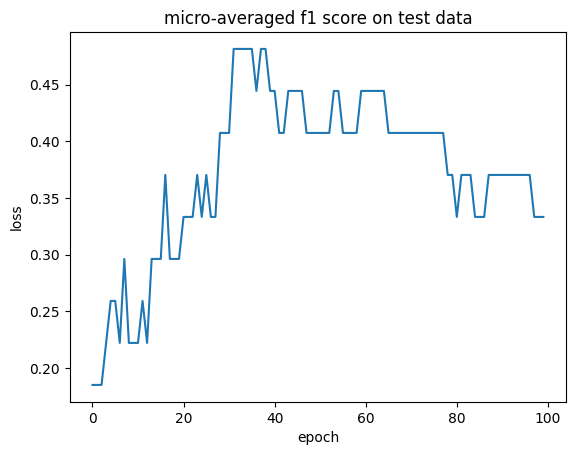

0.9120879120879121 0.3333333333333333


In [12]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_name='APP'
ssl_flag = True

params = {'hidden_layer': 64, "size of network, number of convs": 3, "dropout": 0.1, "lr": 0.01, "coef": 10}
model_training = TrainModelNC(data=dataset, device=device, ssl_flag=ssl_flag, loss_name=loss_name)
model, train_acc_mi, train_acc_ma, test_acc_mi, test_acc_ma = model_training.run(params)
print(train_acc_mi, test_acc_mi)

# Построим объяснения предсказания

Explainer settings
\ A dim:  (131, 131)
\ X dim:  (131, 131)
Explaining node: 2


  0%|          | 0/1000000 [00:00<?, ?it/s]

estimation ['7', '14', '79'] [('79', '7')]
explanations is 2 ['7', '14', '79', '2'] [('79', '7'), ('79', '2')]
2
0
3


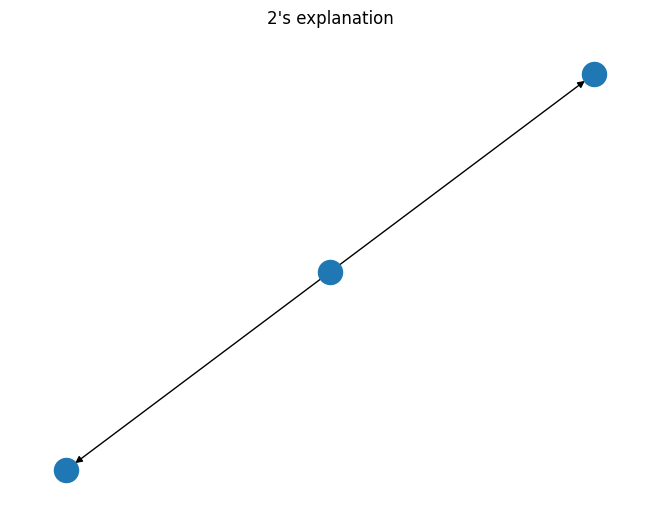

Explaining node: 4


  0%|          | 0/1000000 [00:00<?, ?it/s]

estimation ['49', '79', '123'] []
explanations is 4 ['49', '79', '123', '4'] [('123', '4')]
2
3


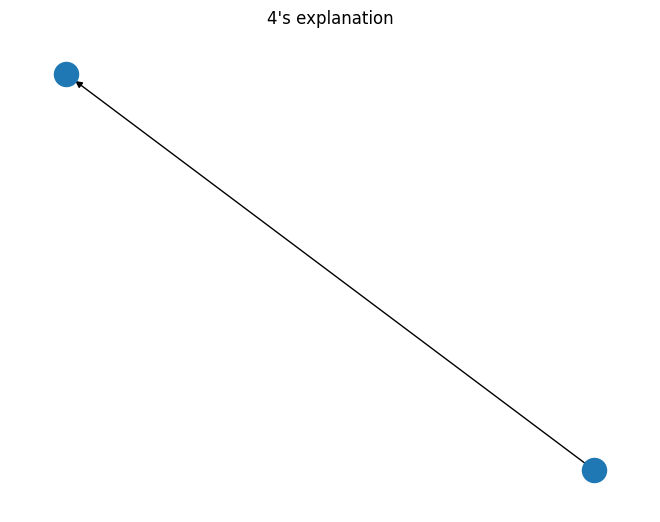

Explaining node: 13


  0%|          | 0/1000000 [00:00<?, ?it/s]

estimation ['29', '70', '114', '120'] []
explanations is 13 ['29', '70', '114', '120', '13'] [('120', '13')]
3
4


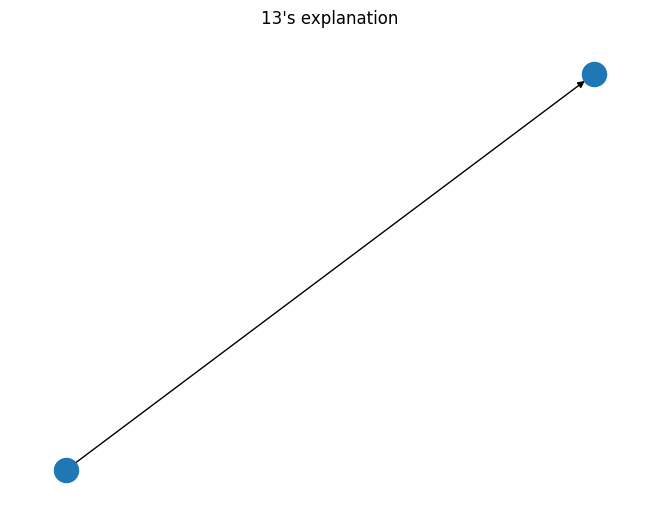

Explaining node: 14


  0%|          | 0/1000000 [00:00<?, ?it/s]

estimation ['48', '106', '111'] []
explanations is 14 ['48', '106', '111', '14'] [('106', '14'), ('111', '14')]
1
3
2


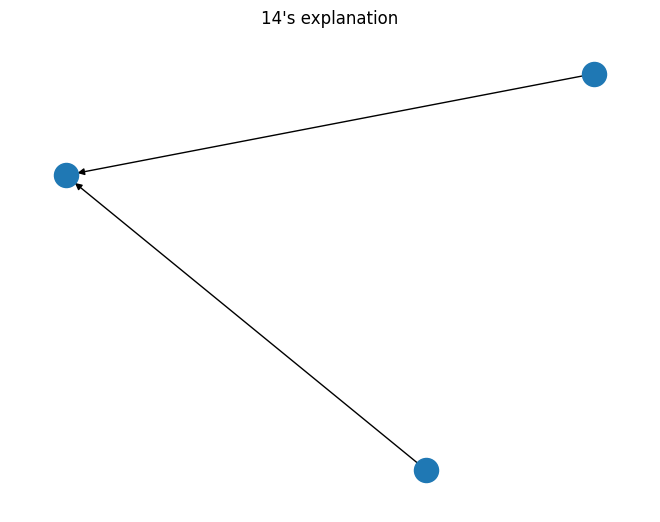

In [30]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.utils import to_dense_adj

from stable_gnn.explain import Explain

root='../data_validation/'
features = np.load(root + name + "/X.npy")
if os.path.exists(root + name + "/A.npy"):
    adj_matrix = np.load(root + name + "/A.npy")
else:
    adj_matrix = torch.squeeze(to_dense_adj(data.edge_index.cpu())).numpy()


explainer = Explain(model=model, adj_matrix=adj_matrix, features=features)

for global_node in [2,4,14,113]:
        pgm_explanation = explainer.structure_learning(global_node)
        print("explanations is", global_node, pgm_explanation.nodes, pgm_explanation.edges)
        g = nx.DiGraph()
        mapping = {}
        inv_mapping = {}
        for i, node in enumerate(pgm_explanation.nodes):
            mapping[node]=i
            inv_mapping[i]=node

        edges = []
        for edge in pgm_explanation.edges:
            edges.append([mapping[edge[0]], mapping[edge[1]]])
        g.add_edges_from(edges)
        for node in g.nodes():
            print(node)
            g.add_node(node)

        plt.figure()
        nx.draw(g)
        plt.title(str(global_node)+'\'s explanation' )
        plt.show()
        plt.close()

# Ego-networks of these nodes

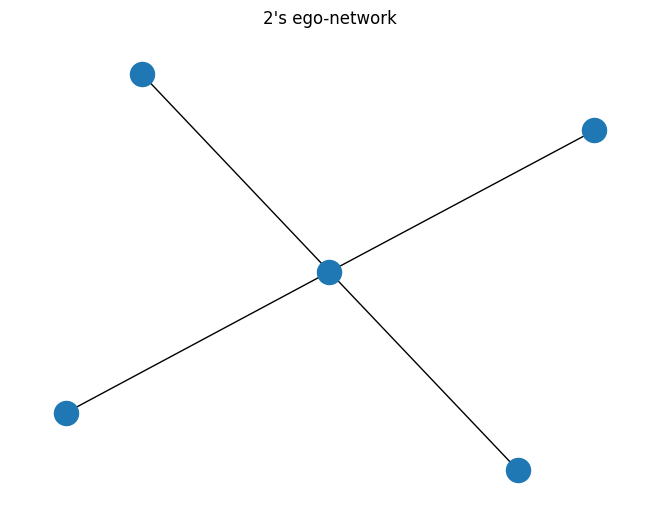

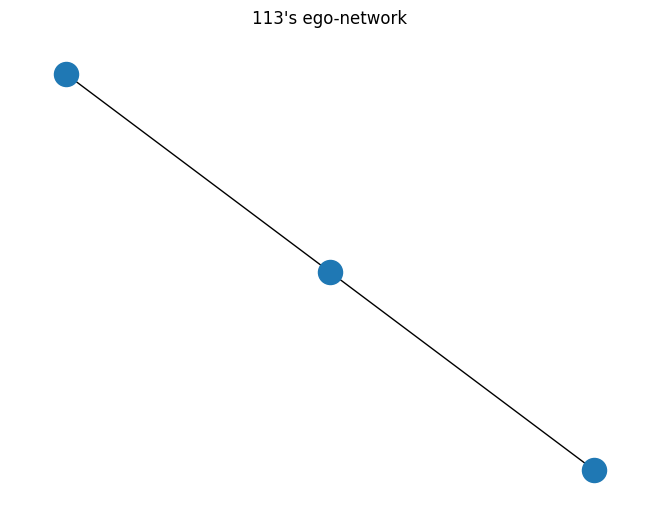

In [24]:
edges = data.edge_index.T.tolist()
G = nx.Graph()
G.add_edges_from(edges)
G.remove_edges_from(nx.selfloop_edges(G))

for global_node in [2,113]:
    g = nx.ego_graph(G,global_node)
    plt.figure()
    nx.draw(g)
    plt.title(str(global_node)+'\'s ego-network' )
    plt.show()
    plt.close()

In [12]:
import networkx as nx
import matplotlib.pyplot as plt